In [15]:
# Important standard packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(69)

In [16]:
# Importing packages used in data pre-processing
import gensim
from gensim.utils import simple_preprocess, tokenize
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora
from nltk.stem.porter import *
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.corpus import stopwords
import string 
from tqdm import tqdm
from pprint import pprint
import time

# Preparing data
1. Loading data and dropping irrelevant columns
2. Removal of NaN values from relevant attributes
3. Create new dataframe consisting of only keywords and country ID

In [10]:
data=pd.read_csv("FAOLEX_ALL.csv")
# print(data.keys())
# print(df.info())
# print(keywords[:5])

# Create simplified version of the dataframe by discarding irrelevant columns 
to_drop = ['Record Id', 
           'Record URL', 
           'Document URL', 
           'Title',
           'Original title',
           'Available website',
           'Abstract']

data.drop(to_drop, inplace=True, axis=1)

In [11]:
# Remove NaN values in the Countries/Territory and Keywords attributes 
data_no_nan = data.dropna(subset=["Country/Territory", "Keywords"])
print(f"This results in {len(data) - len(data_no_nan)} rows being dropped")

This results in 939 rows being dropped


In [12]:
# Remove all documents that have been repealed (Repealed == Y)
data_no_repealed = data_no_nan[data_no_nan.Repealed != 'Y']
print(len(data_no_nan) - len(data_no_repealed))


23106


In [13]:
data_kw = data_no_repealed[["Country/Territory","Keywords"]]
data_kw['index'] = data_kw.index
keywords = data_kw

C:\Users\Jacob pc\AppData\Local\Temp\ipykernel_9356\3997908511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kw['index'] = data_kw.index


# Data pre-processing (v2)
**IMPORTANT**: This is the version of the data pre-processing that should be applied - do not use v1

In [19]:
tokenizer = RegexpTokenizer(r'\w+') # create tokenizer to tokenize docs 
stop_words = stopwords.words('english') # create list of stopwords
p_stemmer = PorterStemmer() # create stemmer instance 


In [20]:
doc_set = keywords["Keywords"].tolist()
processed_kw_list = []

# loop through document list
for i in tqdm(doc_set):
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in stop_words]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    processed_kw_list.append(stemmed_tokens)
    #processed_kw_list.append(stopped_tokens)
    


100%|██████████| 172392/172392 [00:52<00:00, 3290.33it/s]


# LDA model

In [21]:
# Mapping from word IDs to words
# https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920
id2word = corpora.Dictionary(processed_kw_list)

# Prepare Document-Term matrix
corpus = []
for doc in processed_kw_list:
    corpus.append(id2word.doc2bow(doc))

In [22]:
# load lda model
from gensim import  models

lda_model = models.ldamodel.LdaModel.load("lda_model")
n_topics=100

In [23]:
# Compute Coherence Score (the higher the better)
#coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=processed_kw_list, dictionary=id2word, coherence='c_v')
#coherence_lda = coherence_model_lda.get_coherence()
#print('Coherence Score: ', coherence_lda)

# Co-occurence

In [24]:
# Create a list of countries 
all_countries = keywords["Country/Territory"].tolist()

#
countries_new=[]
# Make country dict --> key: country, value: country index
countries = {}
i=0
for coun in all_countries:
    if len(coun.split(";"))>=2:
        for c in coun.split("; "):
            if c in countries.keys():
                countries_new.append(c)
            else:
                countries_new.append(c)
                countries[c]=i
                i+=1
    else:
        if coun in countries.keys():
            countries_new.append(coun)
        else:
            countries_new.append(coun)
            countries[coun]=i
            i+=1
    


In [25]:
countries["Afghanistan"]

216

In [26]:
topic_nums = np.arange(n_topics)

# topic sizes
topic_sizes = np.asarray(np.zeros(n_topics), dtype = 'int')

# list used to store all documents belonging to each individual topic 
documents_in_topics = [[] for _ in range(n_topics)]

for i in tqdm(range(len(corpus))): 
    topics = lda_model.get_document_topics(corpus[i])
    largest_prob = max(topics, key=lambda x: x[1])
    topic_max_prob = largest_prob[0]
    topic_sizes[topic_max_prob] += int(1)

    # fill out the list described above - to be used for further processing
    documents_in_topics[topic_max_prob].append((i, largest_prob[1]))




100%|██████████| 172392/172392 [00:53<00:00, 3248.66it/s]


In [27]:
lda_model.get_document_topics(corpus[2])

[(23, 0.3128067),
 (66, 0.06074134),
 (68, 0.06317527),
 (85, 0.0680385),
 (95, 0.12254667),
 (96, 0.3139412)]

In [28]:
# Sort the documents_in_topics list such that document with the highest probability of belonging to the respective topic
# is placed first in the corresponding sub-list. 

for sub_list in documents_in_topics:
    sub_list.sort(key=lambda x: x[1], reverse=True)

# Create a list as above without the probabilities (such that only the indices are used)
new_documents_in_topics = [[t[0] for t in sublist] for sublist in documents_in_topics]

In [29]:
# Compute country x topic occurence matrix
country_topic_matrix = np.zeros((len(set(countries_new)),len(topic_nums)))

for num in topic_nums:
    # For each topic get the corresponding documents
    document_ids = new_documents_in_topics[num]
    for id in document_ids:
        # Find the documents' countries and add it to the co-occurence matrix
        if len(all_countries[id].split(";"))>=2:
            for c in all_countries[id].split("; "):
                 country_topic_matrix[countries[c],num] +=1
        else:
            country_topic_matrix[countries[all_countries[id]],num] +=1

In [30]:
# Relevant function used in the next section
def square_rooted(x):
   return round(np.sqrt(sum([a*a for a in x])),3)

def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)

In [31]:
def co_occurence(country_new, similarity):
    country_co_occurrence = np.zeros((len(set(country_new)),len(set(country_new))))

    for i in range(len(set(country_new))):
        for j in range(len(set(country_new))):
            if similarity == "correlation":
                # Correlation
                country_co_occurrence[i,j] = np.exp(np.corrcoef(country_topic_matrix[i,:],country_topic_matrix[j,:])[0,1])/np.exp(1)
            elif similarity == "cosine":
                #Cosine similarity:
                country_co_occurrence[i,j] = country_topic_matrix[i,:]@country_topic_matrix[j,:]/(square_rooted(country_topic_matrix[i,:])*square_rooted(country_topic_matrix[j,:]))
            elif similarity == "euclidean":
                # Eucledean distance
                country_co_occurrence[i,j] = np.linalg.norm(country_topic_matrix[i,:]-country_topic_matrix[j,:])
    if similarity == "euclidean":
        country_co_occurrence=1-(country_co_occurrence/np.max(country_co_occurrence))
        
    return country_co_occurrence

country_co_occurrence = co_occurence(countries_new, "correlation")
np.shape(country_co_occurrence)

(257, 257)

In [32]:
#Remove small islands

for i in range(len(set(countries_new))):
    if countries_new.count(countries_swap[i])<=20:
        country_co_occurrence[i] =0
        country_co_occurrence[:,i]=0

# Country networks

In [33]:
# Importing packages to create networks 
from networkx.algorithms.community import girvan_newman
import networkx as nx
import itertools
import matplotlib.pyplot as plt

In [34]:
G = nx.Graph()

size = country_co_occurrence.shape[0]

countries_swap_copy = countries_swap.copy()

G.add_nodes_from(range(size))

for i in range(size):
        for j in range(i+1, size):
            if country_co_occurrence[i, j] != 0.0:
            #if country_co_ocurrence[i, j] > 0.002:
                G.add_edge(i, j, weight=country_co_occurrence[i, j])

for i in range(size):
    if np.sum(country_co_occurrence[i])==0:
        G.remove_node(i)
        countries_swap_copy.pop(i)


# Community detection

In [35]:
from networkx.algorithms.community import louvain_communities
comms = louvain_communities(G,weight="weight",resolution=1.3,seed=69)
unique_coms = np.unique(list(comms))

In [36]:
community_assignment = {}

# Assign community indices to nodes
for i, community in enumerate(comms):
    for node in community:
        community_assignment[node] = i

# Create a list of colors for each node based on the community assignment
node_colors = [community_assignment.get(node, -1) for node in G.nodes()]

# Draw the graph with different colors for different communities
#pos = nx.spring_layout(G)  # Positions of nodes in the graph layout
#nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=200)
#nx.draw_networkx_edges(G, pos)
#nx.draw_networkx_labels(G, pos,labels=countries_swap_copy)
#plt.show()


In [37]:
resolution=np.arange(0.9,2.0,0.01)
scores=np.zeros(len(resolution))
j=0
for res in resolution:
    comms = louvain_communities(G,weight="weight",resolution=res,seed=69)
    unique_coms = np.unique(list(comms))
    i=1
    communities={}
    for community in comms:
        #print("c",i)
        com_countries = []
        for c in community:
            #print(countries_swap[c])
            com_countries.append(c)
        communities[i] = com_countries
        i=i+1
    for com in communities.values():
        if len(com)==1:
            scores[j]+=1
        elif len(com)>=30:
            scores[j]+=len(com)-29
    j+=1

In [38]:
res_op=np.argmin(scores)
comms = louvain_communities(G,weight="weight",resolution=resolution[res_op],seed=69)
unique_coms = np.unique(list(comms))
i=1
communities={}
for community in comms:
        print("c",i)
        com_countries = []
        for c in community:
            print(countries_swap[c])
            com_countries.append(c)
        communities[i] = com_countries
        i=i+1

community_assignment = {}
for i, community in enumerate(comms):
    for node in community:
        community_assignment[node] = i

c 1
Comoros
Eritrea
c 2
Solomon Islands
Suriname
Congo
Côte d'Ivoire
Viet Nam
Central African Republic
Lao People's Democratic Republic
Sierra Leone
Paraguay
Cameroon
Togo
Democratic Republic of the Congo
French Guiana (France)
Zambia
Indonesia
Grenada
Bhutan
Saint Lucia
Liberia
Gabon
Haiti
Arunachal Pradesh (India)
Jammu and Kashmir (India)
Russian Federation
Equatorial Guinea
Guatemala
Sri Lanka
c 3
Gambia
United States of America
India
c 4
Algeria
Djibouti
c 5
Republic of Korea
Puerto Rico (USA)
c 6
Argentina
Mexico
Morocco
c 7
South Africa
Portugal
c 8
Latvia
Singapore
Republic of Moldova
Thailand
China, Macao SAR
Cuba
Taiwan Province of China
El Salvador
China
c 9
Guinea
Madagascar
c 10
Myanmar
Nicaragua
c 11
Maldives
Pitcairn (UK)
c 12
Albania
c 13
Malaysia
c 14
Monaco
Qatar
United Arab Emirates
Oman
Libya
French Polynesia (France)
Saudi Arabia
c 15
Kenya
Zanzibar (United Republic of Tanzania)
Malawi
c 16
Andean Community
Panama
c 17
Ukraine
Jordan
Georgia
Tajikistan
Iran (Islami

# Find internal topics in communtities

In [39]:
country_topic_matrix_prob =np.copy(country_topic_matrix)

for i in range(np.shape(country_topic_matrix)[1]):
    country_topic_matrix_prob[:,i] = country_topic_matrix_prob[:,i]/np.sum(country_topic_matrix_prob[:,1])
i=1
for com in communities.values():
    topics_in_com=[]
    if len(com)>1:
        for c in com:
            topics_in_com.append(np.argsort(country_topic_matrix_prob[c,:])[::-1][:5])
        print("Topics i community",i, "er: ", set([x for x in np.concatenate(topics_in_com) if list(np.concatenate(topics_in_com)).count(x) >= 2*len(com)/3]))
    i+=1

Topics i community 1 er:  {12, 13}
Topics i community 2 er:  {13, 14}
Topics i community 3 er:  {59, 37, 14, 39}
Topics i community 4 er:  {13, 78, 31}
Topics i community 5 er:  {91, 14}
Topics i community 6 er:  {96, 14}
Topics i community 7 er:  {59, 92}
Topics i community 8 er:  {24, 92}
Topics i community 9 er:  {96, 13, 14}
Topics i community 10 er:  {24, 59}
Topics i community 11 er:  {25, 23, 95}
Topics i community 14 er:  set()
Topics i community 15 er:  {59, 2, 91, 13}
Topics i community 16 er:  {59, 36}
Topics i community 17 er:  {13, 78}
Topics i community 18 er:  {91}
Topics i community 19 er:  {88, 78, 14}
Topics i community 20 er:  {92, 13}
Topics i community 21 er:  {92}
Topics i community 22 er:  {24, 19, 59, 13}
Topics i community 23 er:  {59}
Topics i community 24 er:  {59, 13}
Topics i community 25 er:  {96, 13}
Topics i community 26 er:  {96, 25}


# Comparing communities to income-levels

In [40]:
#country-income data
income = pd.read_excel("CLASS.xlsx")
print(income.keys())

Index(['Economy', 'Code', 'Region', 'Income group', 'Lending category',
       'Other (EMU or HIPC)'],
      dtype='object')


In [41]:
income_countries = list(income["Economy"])
income_groups = list(income["Income group"])
income_listed_countries =[]
countries_income_dic ={}
for i in range(len(income_countries)):
    for j in range(len(countries_swap)):
        if income_countries[i] == countries_swap[j]:
            income_listed_countries.append(j)
            if income_groups[i] == "Low income":
                countries_income_dic[j]= 0
            elif income_groups[i] == "Lower middle income":
                countries_income_dic[j]= 1
            elif income_groups[i] == "Upper middle income":
                countries_income_dic[j]= 2
            elif income_groups[i] == "High income":
                countries_income_dic[j]= 3
missing_income_countries = []
missing_income_countries_names=[]
for i in countries_swap.keys():
    if i not in income_listed_countries:
        missing_income_countries.append(i)
        missing_income_countries_names.append(countries_swap[i])

In [42]:
from fuzzywuzzy import process
matches = []
threshold = 90  # Adjust the threshold as per your needs

for country1 in missing_income_countries_names:
    best_match = process.extractOne(country1, income_countries)
    if best_match[1] >= threshold:
        matches.append((country1, best_match[0]))


# Print the matches
for match in matches:
    print("Match:", match[0], "-", match[1])

print(len(matches))
print("matches found")

C:\Users\Jacob pc\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Match: Bermuda (UK) - Bermuda
Match: British Virgin Islands (UK) - British Virgin Islands
Match: United States of America - United States
Match: Saint Kitts and Nevis - St. Kitts and Nevis
Match: Saint Vincent and the Grenadines - St. Vincent and the Grenadines
Match: Cayman Islands (UK) - Cayman Islands
Match: Greenland (Denmark) - Denmark
Match: China, Hong Kong SAR - Hong Kong SAR, China
Match: Bolivia (Plurinational State of) - Bolivia
Match: United Kingdom of Great Britain and Northern Ireland - United Kingdom
Match: Côte d'Ivoire - Côte d’Ivoire
Match: Sao Tome and Principe - São Tomé and Príncipe
Match: Netherlands Antilles (Netherlands) - Netherlands
Match: United Republic of Tanzania - Tanzania
Match: Congo - Congo, Dem. Rep.
Match: Viet Nam - Vietnam
Match: Gambia - Gambia, The
Match: French Guiana (France) - France
Match: Niue (New Zealand) - New Zealand
Match: Guadeloupe (France) - France
Match: Martinique (France) - France
Match: Réunion (France) - France
Match: Egypt - Eg

In [43]:
#manual_income =  [(0,3),(1,3),(5,3),(8,3),(12,3),(13,3),()]
for i,j in matches:
    if income_groups[income_countries.index(j)] == "Low income":
        countries_income_dic[countries[i]]= 0
    elif income_groups[income_countries.index(j)] == "Lower middle income":
        countries_income_dic[countries[i]]= 1
    elif income_groups[income_countries.index(j)] == "Upper middle income":
        countries_income_dic[countries[i]]= 2
    elif income_groups[income_countries.index(j)] == "High income":
        countries_income_dic[countries[i]]= 3


missing_income_countries = []
missing_income_countries_names=[]
for i in countries_swap.keys():
    if i not in countries_income_dic.keys():
        missing_income_countries.append(i)
        missing_income_countries_names.append(countries_swap[i])

In [44]:
extra_countries = [('Saint Barthélemy (FRA)',3),('Kyrgyzstan',1),('Andean Community',2),('Palestine',1),('Iran (Islamic Republic of)',1),('Slovakia',3),('Saint Helena, Ascension and Tristan da Cunha (UK)',3),('Jersey  (UK)',3),('Montserrat (UK)',3),('European Union',3),("Democratic People's Republic of Korea",0),('Falkland Islands (Malvinas)',3),
('Anguilla (UK)',3),('Cook Islands',3),('Micronesia (Federated States of)',1),('Republic of Korea',3),('MERCOSUR',2),('Democratic Republic of the Congo',0),('Guernsey (UK)',3),('Saint Lucia',2),('Czechia',3),('Venezuela (Bolivarian Republic of)',1),('Pitcairn (UK)',3),("Lao People's Democratic Republic",1)]

for i,j in extra_countries:
    countries_income_dic[countries[i]]= j


In [45]:
# Compare countries income: function takes a list of country indexes and returns the rang between lowest and higest income country and the standard deviation
def check_income(community):
    com_income = []
    for i in community:
        com_income.append(countries_income_dic[i])
    range = max(com_income)-min(com_income)
    std = np.std(com_income)
    return range, std

Text(0.5, 1.0, 'Countries in communities from LDA model highlighted by income level')

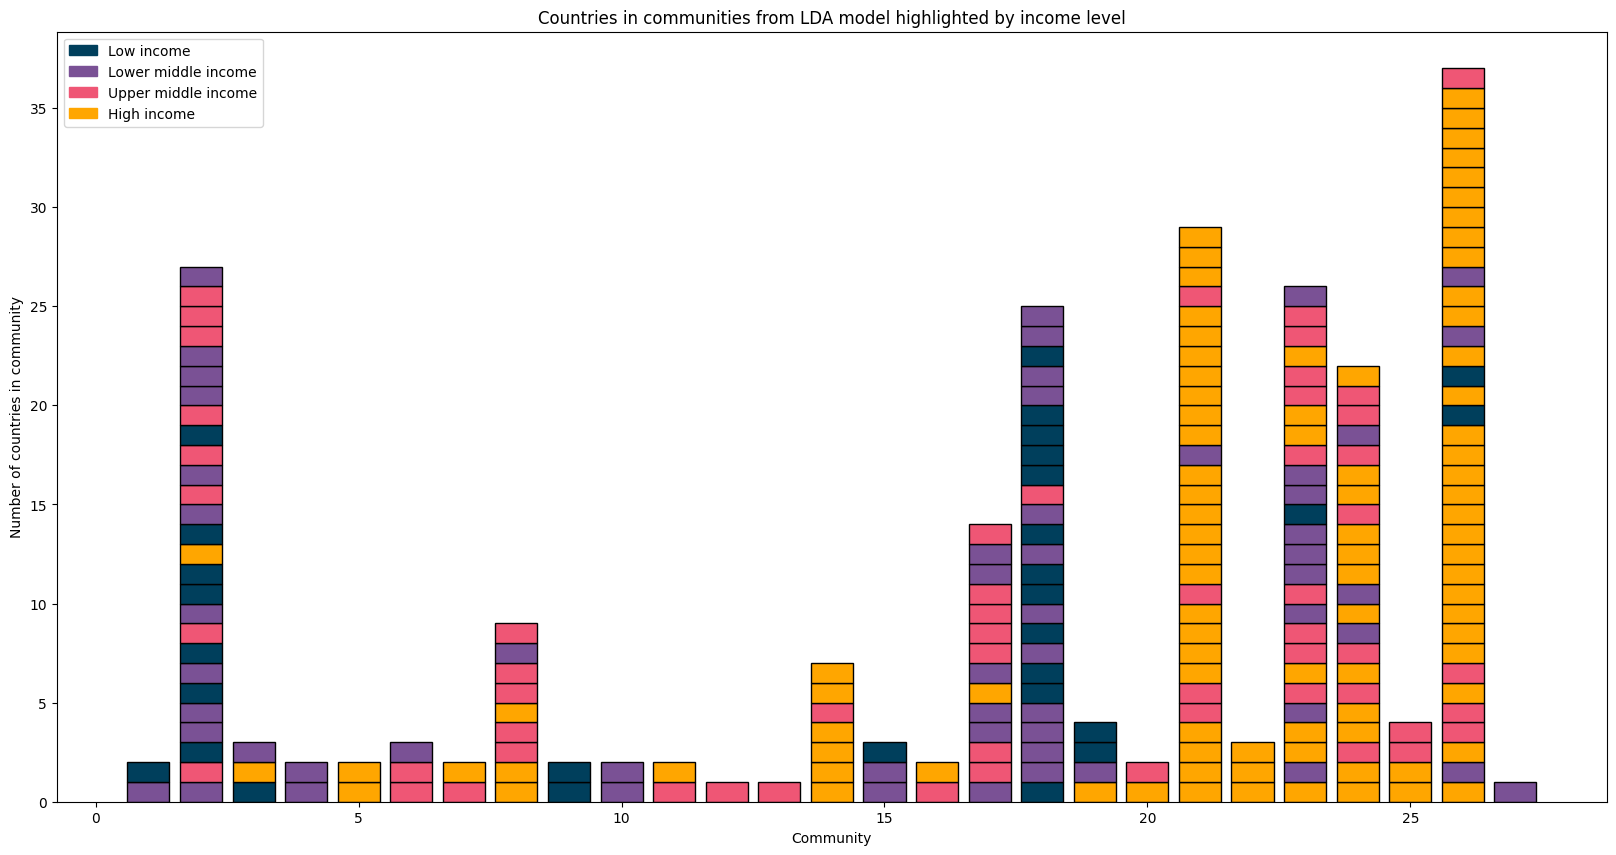

In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure(figsize=(20, 10))
for j in range(len(communities)):
    for i in range(len(communities[j+1])):
        if i == 0:
            if countries_income_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 1, color="#003f5c",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 1, color="#7a5195",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 1, color="#ef5675",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 1, color="#ffa600",width=0.8,edgecolor="#000000")
            h=1
        else:
            if countries_income_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 1, bottom=h, color="#003f5c",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 1, bottom=h, color="#7a5195",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 1, bottom=h, color="#ef5675",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 1, bottom=h, color="#ffa600",width=0.8,edgecolor="#000000")
            h=h+1
pop_a = mpatches.Patch(color='#003f5c', label="Low income")
pop_b = mpatches.Patch(color='#7a5195', label="Lower middle income")
pop_c = mpatches.Patch(color='#ef5675', label="Upper middle income")
pop_d = mpatches.Patch(color='#ffa600', label='High income')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d])
plt.xlabel("Community")
plt.ylabel("Number of countries in community")
plt.title("Countries in communities from LDA model highlighted by income level")


# Governance

In [47]:
#country governance data
governance = pd.read_excel("governence data update.xlsx")
print(governance.keys())
governance_country = []
categorized_governance = []

for est,c in zip(governance["Estimate"],governance["Country/Territory"]):
    if est >=1:
        categorized_governance.append(3)
        governance_country.append(c)
    elif est>=0 and est<1:
        categorized_governance.append(2)
        governance_country.append(c)
    elif est>-1 and est<0:
        categorized_governance.append(1)
        governance_country.append(c)
    elif est<=-1:
        categorized_governance.append(0)
        governance_country.append(c)

#income_countries = list(income["Economy"])
#income_groups = list(income["Income group"])
governance_listed_countries =[]
governance_dic={}
for i in range(len(governance_country)):
    for j in range(len(countries_swap)):
        if governance_country[i] == countries_swap[j]:
            governance_listed_countries.append(j)
            governance_dic[j]=categorized_governance[i]
missing_gov_countries = []
missing_gov_countries_names=[]
for i in countries_swap.keys():
    if i not in governance_listed_countries:
        missing_gov_countries.append(i)
        missing_gov_countries_names.append(countries_swap[i])

from fuzzywuzzy import process
matches = []
threshold = 90  # Adjust the threshold as per your needs

for country1 in missing_gov_countries_names:
    best_match = process.extractOne(country1, governance_country)
    if best_match[1] >= threshold:
        matches.append((country1, best_match[0]))


# Print the matches
for match in matches:
    print("Match:", match[0], "-", match[1])

print(len(matches))
print("matches found")

Index(['Country/Territory', 'Estimate'], dtype='object')
Match: United States of America - United States
Match: Saint Kitts and Nevis - St. Kitts and Nevis
Match: Saint Vincent and the Grenadines - St. Vincent and the Grenadines
Match: Cayman Islands (UK) - Cayman Islands
Match: Greenland (Denmark) - Denmark
Match: China, Hong Kong SAR - Hong Kong SAR, China
Match: Bolivia (Plurinational State of) - Bolivia
Match: United Kingdom of Great Britain and Northern Ireland - United Kingdom
Match: Sao Tome and Principe - São Tomé and Principe
Match: Netherlands Antilles (Netherlands) - Netherlands
Match: United Republic of Tanzania - Tanzania
Match: Congo - Congo, Rep.
Match: Viet Nam - Vietnam
Match: Gambia - Gambia, The
Match: French Guiana (France) - France
Match: Niue (New Zealand) - Niue
Match: Guadeloupe (France) - France
Match: Martinique (France) - France
Match: Réunion (France) - France
Match: Egypt - Egypt, Arab Rep.
Match: Bahamas - Bahamas, The
Match: Mayotte (France) - France
Matc

In [48]:
for i,j in matches:
    governance_dic[countries[i]]=categorized_governance[governance_country.index(j)]

missing_gov_countries = []
missing_gov_countries_names=[]
for i in countries_swap.keys():
    if i not in governance_dic.keys():
        missing_gov_countries.append(i)
        missing_gov_countries_names.append(countries_swap[i])
# Extra countries, 5 = Nan
extra_countries = [('Saint Barthélemy (FRA)',5),("Isle of Man (UK)",5),('Kyrgyzstan',1),('Andean Community',5),('Palestine',0),('Iran (Islamic Republic of)',0),('Slovakia',2),("Curaçao",5),('Saint Helena, Ascension and Tristan da Cunha (UK)',5),('Jersey  (UK)',3),('Montserrat (UK)',3),("Bermuda (UK)",5),("Cabo Verde",5),('European Union',5),("Democratic People's Republic of Korea",0),('Falkland Islands (Malvinas)',5),
('Anguilla (UK)',5),('Cook Islands',3),('Micronesia (Federated States of)',3),('Republic of Korea',2),("Northern Mariana Islands (USA)",3),('MERCOSUR',5),("British Virgin Islands (UK)",5),('Democratic Republic of the Congo',0),('Guernsey (UK)',3),('Saint Lucia',2),('Czechia',3),('Venezuela (Bolivarian Republic of)',0),('Pitcairn (UK)',3),("Lao People's Democratic Republic",0),("Turks and Caicos Islands (UK)",5),("Gibraltar (UK)",5),
("Taiwan Province of China",3),("South Georgia and the South Sandwich Islands (UK)",5)]


for i,j in extra_countries:
    governance_dic[countries[i]]= j



Text(0.5, 1.0, 'Countries in communities from Top2Vec model highlighted by government effectiveness')

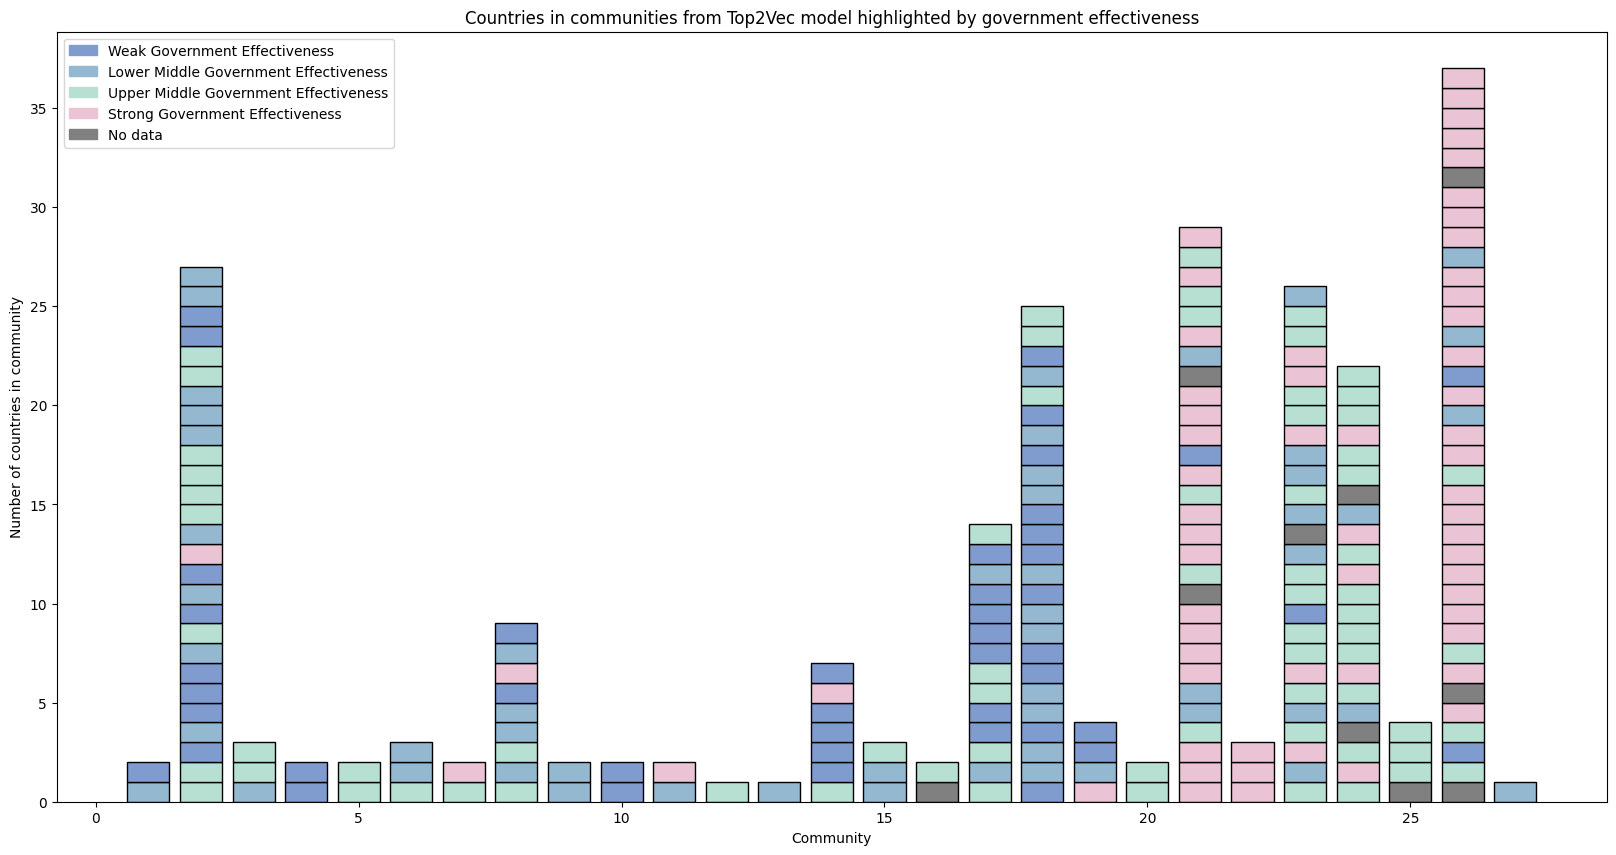

In [49]:
plt.figure(figsize=(20, 10))
for j in range(len(communities)):
    for i in range(len(communities[j+1])):
        if i == 0:
            if governance_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 1, color="#809bce",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 1, color="#95b8d1",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 1, color="#b8e0d2",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 1, color="#eac4d5",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 5:
                plt.bar(j+1, 1, color="#808080",width=0.8,edgecolor="#000000")
            h=1
        else:
            if governance_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 1, bottom=h, color="#809bce",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 1, bottom=h, color="#95b8d1",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 1, bottom=h, color="#b8e0d2",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 1, bottom=h, color="#eac4d5",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 5:
                plt.bar(j+1, 1, bottom=h, color="#808080",width=0.8,edgecolor="#000000")
            h=h+1
pop_a = mpatches.Patch(color='#809bce', label="Weak Government Effectiveness")
pop_b = mpatches.Patch(color='#95b8d1', label="Lower Middle Government Effectiveness")
pop_c = mpatches.Patch(color='#b8e0d2', label="Upper Middle Government Effectiveness")
pop_d = mpatches.Patch(color='#eac4d5', label='Strong Government Effectiveness')
pop_e = mpatches.Patch(color='#808080', label='No data')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d,pop_e])
plt.xlabel("Community")
plt.ylabel("Number of countries in community")
plt.title("Countries in communities from Top2Vec model highlighted by government effectiveness")

In [50]:
for c in communities[26]:
    print(countries_swap[c],governance_dic[c])

Isle of Man (UK) 5
Papua New Guinea 2
Bahrain 0
Tonga 2
Tuvalu 3
British Virgin Islands (UK) 5
Marshall Islands 3
Nauru 2
Niue (New Zealand) 3
Cook Islands 3
Greenland (Denmark) 3
Guadeloupe (France) 3
Martinique (France) 3
Réunion (France) 3
Uruguay 3
Mayotte (France) 3
Chile 2
Tokelau (New Zealand) 3
New Caledonia (France) 3
Guinea-Bissau 1
Iceland 3
Yemen 0
Jan Mayen (Norway) 3
Mauritania 1
Svalbard (Norway) 3
Jersey  (UK) 3
Kiribati 3
Kuwait 1
Northern Mariana Islands (USA) 3
Aruba (Netherlands) 3
Saint Pierre and Miquelon (France) 3
European Union 5
Faroe Islands (Denmark) 3
New Zealand 3
Netherlands Antilles (Netherlands) 3
Norway 3
Palau 3


# Temperature

In [51]:
#country temperature data
temperature = pd.read_excel("hottest-countries-in-the-world-2023.xlsx")
print(temperature.keys())
temperature_country = list(temperature["country"])
temp = list(temperature["averageTemperature"])

Index(['country', 'averageTemperature'], dtype='object')


In [52]:
for i in range(len(temp)):
    if temp[i]<=5:
        temp[i]=0
    elif temp[i]> 5 and temp[i]<=14:
        temp[i]=1
    elif temp[i]>14 and temp[i]<=23:
        temp[i]=2
    elif temp[i] >23:
        temp[i]=3

In [53]:
temp_listed_countries =[]
temp_dic={}
for i in range(len(temperature_country)):
    for j in range(len(countries_swap)):
        if temperature_country[i] == countries_swap[j]:
            temp_listed_countries.append(j)
            temp_dic[j]=temp[i]
missing_temp_countries = []
missing_temp_countries_names=[]
for i in countries_swap.keys():
    if i not in temp_listed_countries:
        missing_temp_countries.append(i)
        missing_temp_countries_names.append(countries_swap[i])

In [54]:
for c in countries_swap.keys():
    if c not in temp_dic.keys():
        temp_dic[c] = "NaN"

Text(0.5, 1.0, 'Countries in communities from Top2Vec model highlighted by mean temperature')

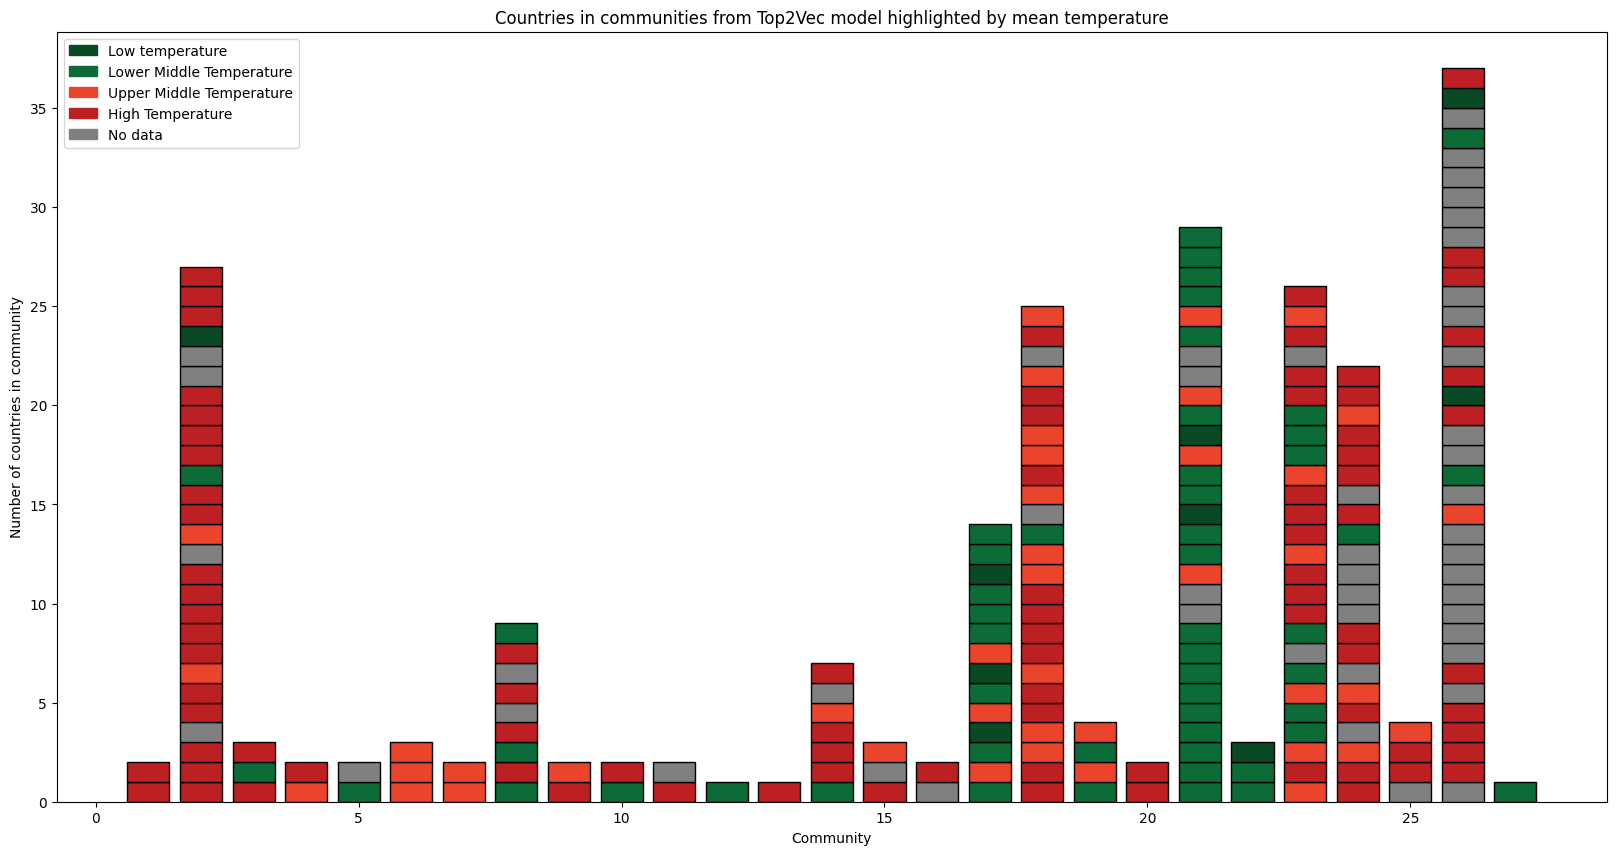

In [61]:
plt.figure(figsize=(20, 10))
for j in range(len(communities)):
    for i in range(len(communities[j+1])):
        if i == 0:
            if temp_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 1, color="#094A25",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 1, color="#0C6B37",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 1, color="#EB442C",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 1, color="#BC2023",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == "NaN":
                plt.bar(j+1, 1, color="#808080",width=0.8,edgecolor="#000000")
            h=1
        else:
            if temp_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 1, bottom=h, color="#094A25",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 1, bottom=h, color="#0C6B37",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 1, bottom=h, color="#EB442C",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 1, bottom=h, color="#BC2023",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == "NaN":
                plt.bar(j+1, 1, bottom=h, color="#808080",width=0.8,edgecolor="#000000")
            h=h+1
pop_a = mpatches.Patch(color='#094A25', label="Low temperature")
pop_b = mpatches.Patch(color='#0C6B37', label="Lower Middle Temperature")
pop_c = mpatches.Patch(color='#EB442C', label="Upper Middle Temperature")
pop_d = mpatches.Patch(color='#BC2023', label='High Temperature')
pop_e = mpatches.Patch(color='#808080', label='No data')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d,pop_e])
plt.xlabel("Community")
plt.ylabel("Number of countries in community")
plt.title("Countries in communities from Top2Vec model highlighted by mean temperature")

# Word cloud visualization

In [56]:
from wordcloud import WordCloud

In [57]:
# Get the topics which most topics are categorized as. 
indices = np.argsort(topic_sizes)[-5:][::-1]
print(indices)

[59 92 13 14 96]


In [58]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic, topn = 50)}
    wc = WordCloud(background_color="black",width=4000, height = 1000, max_words=50, relative_scaling=0.2)
    wc.generate_from_frequencies(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ "3")
    plt.show()

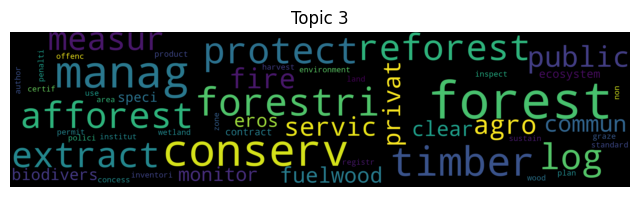

In [59]:
create_wordcloud(lda_model,14)

In [60]:
# mutual imformation calculation

# data pre-processing
c_assign = []
for i in range(500):
    if i in community_assignment:
        c_assign.append(community_assignment[i])

XX = []
for i in range(500):
    if i in countries_income_dic:
        XX.append(countries_income_dic[i])

XX2 = []
for i in range(500):
    if i in community_assignment:
        XX2.append(XX[i])

XXX = []
for i in range(500):
    if i in governance_dic:
        XXX.append(governance_dic[i])

XXX3 = []
for i in range(500):
    if i in community_assignment:
        XXX3.append(XXX[i])
from sklearn.metrics import normalized_mutual_info_score

X = []

for i in range(500):
    if i in temp_dic:
        X.append(temp_dic[i])

X2 = []
for i in temp_dic:
    if i in community_assignment:
        X2.append(X[i])

mi1 = normalized_mutual_info_score(XX2, c_assign)
print("normalized mi for income ", mi1)

mi2 = normalized_mutual_info_score(XXX3, c_assign)
print("normalized mi for governance ", mi2)

mi3 = normalized_mutual_info_score(X2, c_assign)
print("normalized mi for temp ", mi3)

normalized mi for income  0.2391659819912309
normalized mi for governance  0.235724947294272
normalized mi for temp  0.11763934043912354
